In [4]:
import numpy as np
import sys
import itertools
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
sys.path.insert(0, '../code')
import cheauder_utils
from vae_smiles import CustomVariationalLayer

encoder196 = cheauder_utils.load_coder_json(
    "../code/model/vae_encoder_196.json",
    "../code/weights/vae_encoder_196_weights.h5",
    custom_objects={'CustomVariationalLayer': CustomVariationalLayer,
    'latent_dim': 196}
)

decoder196 = cheauder_utils.load_coder_json(
    "../code/model/vae_decoder_196.json",
    "../code/weights/vae_decoder_196_weights.h5",
    custom_objects={'CustomVariationalLayer': CustomVariationalLayer,
    'latent_dim': 196}
)

encoder2 = cheauder_utils.load_coder_json(
    "../code/model/encoder_2.json",
    "../code/weights/encoder_2_weights.h5",
    custom_objects={'CustomVariationalLayer': CustomVariationalLayer,
    'latent_dim': 2}
)

decoder2 = cheauder_utils.load_coder_json(
    "../code/model/decoder_2.json",
    "../code/weights/decoder_2_weights.h5",
    custom_objects={'CustomVariationalLayer': CustomVariationalLayer,
    'latent_dim': 2}
)

X, y, charset, chars = cheauder_utils.load_data_vae('../data/250k_rndm_zinc_drugs_clean_3.csv', charset_filename='../code/model/charset_ZINC35.json',col_smiles=0, col_target=1, delimiter=',', max_len=120)
_, x_test, _, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Kodiranje/Dekodiranje pri variacijskem avtokodirniku

Probali bomo naš naučen variacijski avtokodirnik na molekuli vzeti iz validacijske množice.

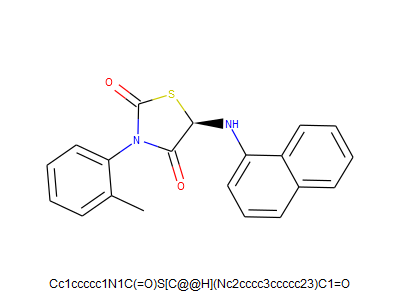

In [39]:
from rdkit import DataStructs, Chem
from rdkit.Chem import AllChem, Draw
smile = cheauder_utils.devectorize_smile(x_test[21], chars)
#smile = 'CSCC(=O)NNC(=O)c1c(C)oc(C)c1C'
mol = Chem.MolFromSmiles(smile)
AllChem.Compute2DCoords(mol)
Draw.MolsToGridImage([mol], 1,(400,300) , legends=[smile])

Potek kodiranja in dekodiranja je naslednji. Zapis SMILES molekule najprej zakodiramo one-hot, dobimo seznam velikosti (120,36). Ta seznam spustimo skozi kodirnik in dobimo vektorsko vložitev te molekule v latentnem prostoru našega variacijskega avtokodirnika dimenzije 196. To vložitev spustimo čez dekodirnik. Dobimo seznam enake dimenzije kot je vhod v kodirnik. Vendar vrednosti niso samo 0 ali 1, vendar dobimo verjetnosti. Torej vzamemo vsak znak pri katerem je verjetnost največja in nastavimo vrednost na 1, ostale pa na 0. Tak seznam lahko pretvorimo nazaj v zapis SMILES.

In [40]:
vec = cheauder_utils.vectorize_smile(smile, charset)
z,_,_ = encoder196.predict(np.array([vec]))
pred = decoder196.predict(z)[0]
pred = np.array((pred.argmax(axis=1)[:, None] == np.arange(pred.shape[1])).astype(int))
pred = cheauder_utils.devectorize_smile(pred, chars)
print('Vhod          : {}'.format(smile))
print('Rekonstrukcija: {}'.format(pred))

Vhod          : Cc1ccccc1N1C(=O)S[C@@H](Nc2cccc3ccccc23)C1=O
Rekonstrukcija: Cc1ccccc1N1C(=O)C[C@@H](Cc2cccc3ccccc23)C1=O


Vidimo, da se zapisa razlikujeta le v dveh znakih. Čeprav sta zapisa zelo podobna pa vendar naša rekonstrukcija ni ustrezen zapis SMILES in ga posledično ne moremo izrisati.

In [49]:
cheauder_utils.is_valid_smiles(pred)

False

Vendar so variacijski avtokodirniki probabilistični. Zato naši vektorski vložitvi dodamo šum. V sorodnih člankih uporabljajo število poskusov med 500 in 1000.

In [50]:
n = 100
noise_norm = 5
valid = dict()
for i in range(n):
    pred = decoder196.predict(np.array(cheauder_utils.perturb_z(z, noise_norm=False if i == 0 else noise_norm)))[0]
    pred = np.array((pred.argmax(axis=1)[:, None] == np.arange(pred.shape[1])).astype(int))
    pred = cheauder_utils.devectorize_smile(pred, chars)
    if cheauder_utils.is_valid_smiles(pred):
        valid[pred] = 1
#    if np.array_equal(smile, pred):
#        print('Poskus št. {} : {}'.format(str(i), pred))
#        break
valid

{'Cc1ccccc1N1C(=O)C[C@@H](Cc2cccc3ccccc23)C1=O': 1,
 'Cc1ccccc1N1C(=O)C[C@@H](Nc2cccc3ccccc23)C1=O': 1,
 'Cc1ccccc1N1C(=O)O[C@@H](Cc2cccc3ccccc23)C1=O': 1,
 'Cc1ccccc1N1C(=O)C[C@@H](Sc2cccc3ccccc23)C1=O': 1,
 'Cc1ccccc1N1C(=O)C[C@@H](Cc2cccc3ccccc23)CC1=O': 1,
 'Cc1ccccc1N1C(=O)S[C@@H](Nc2cccc3ccccc23)C1=O': 1,
 'Cc1ccccc1N1C(=O)N[C@@H](Cc2cccc3ccccc23)C1=O': 1,
 'Cc1ccccc1N1C(=O)S[C@@H](Cc2cccc3ccccc23)C1=O': 1,
 'Cc1ccccc1N1C(=O)C[C@@H](Sc2cccc3ccccc23)CC1=O': 1,
 'Cc1ccccc1N1C(=O)N[C@@H](Sc2cccc3ccccc23)C1=O': 1,
 'Cc1ccccc1N1C(=O)C[C@@H](Sc2nccc3ccccc23)C1=O': 1,
 'Cc1ccccc1N1C(=O)C[C@@H](Nc1cccc3ccccc13)C1=O': 1,
 'Cc1ccccc1N1C(=O)S[C@@H](Sc2cccc3ccccc23)C1=O': 1,
 'Cc1ccccc1N1C(=O)O[C@@H](Oc2cccc3ccccc23)C1=O': 1}

Izrišemo še vse dobljene molekule.

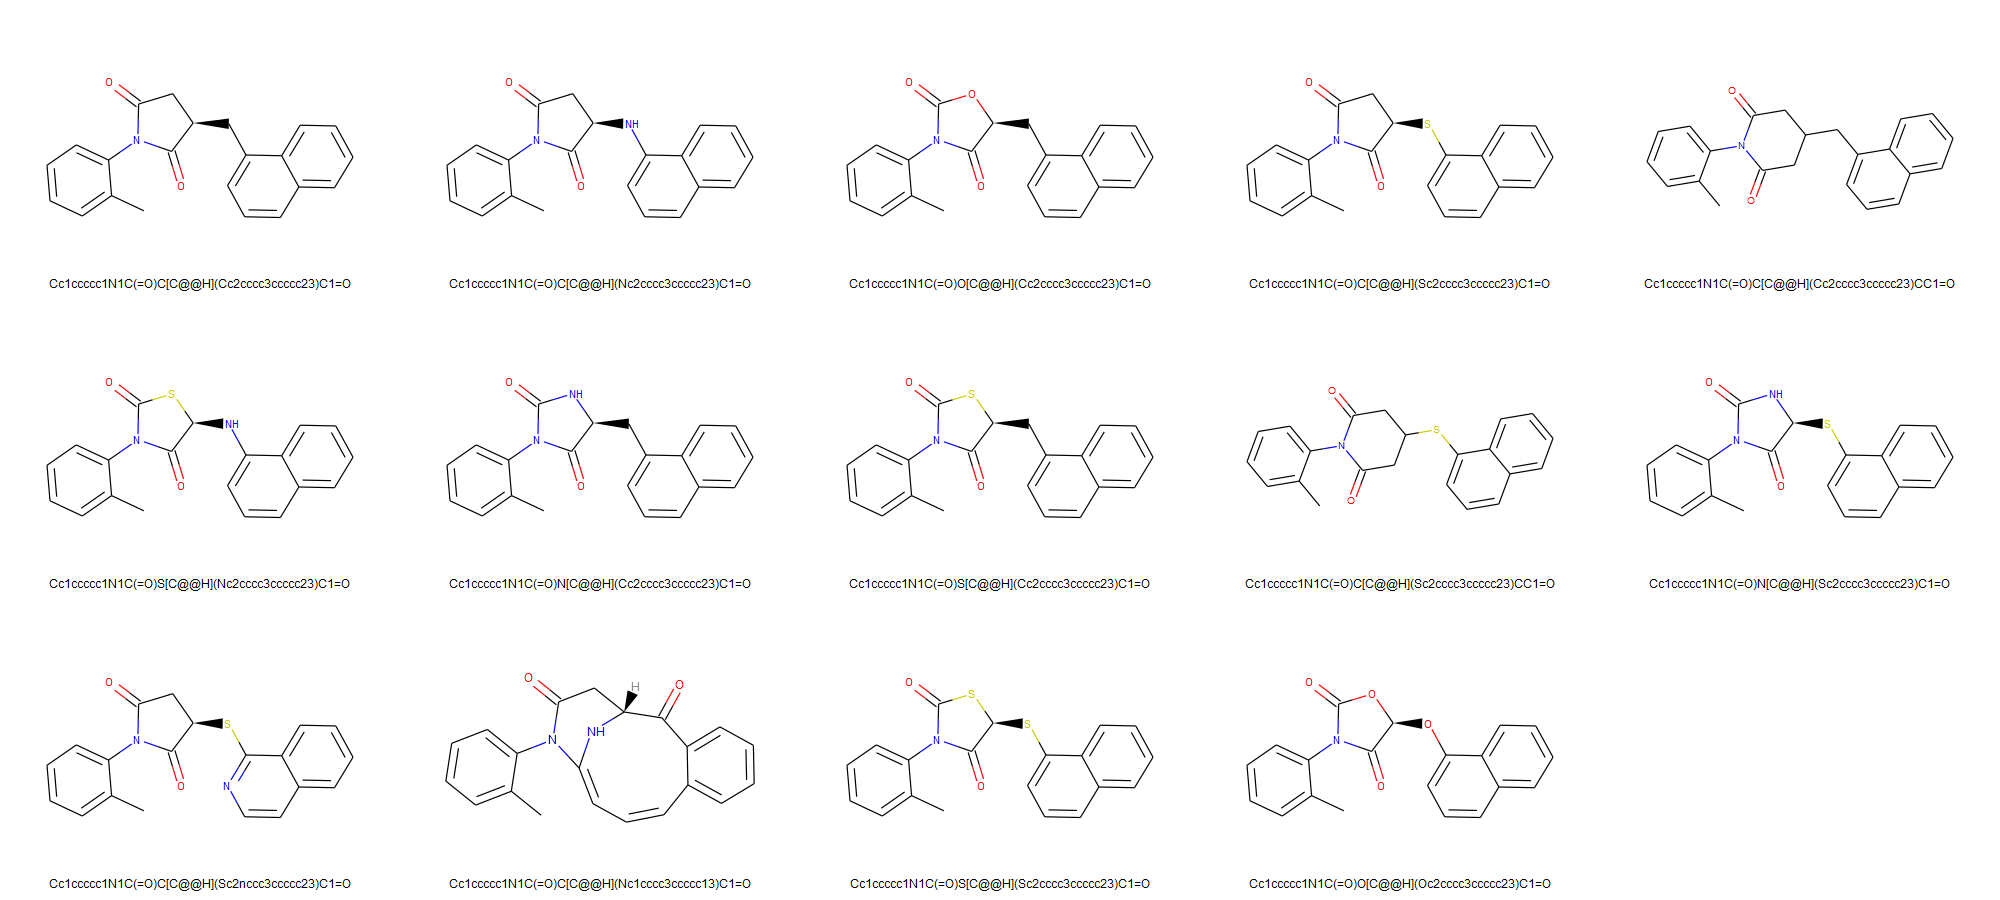

In [54]:
mols = [Chem.MolFromSmiles(s) for s in valid.keys()]
[AllChem.Compute2DCoords(m) for m in mols]
Draw.MolsToGridImage(mols, 5, (400,300), legends=list(valid.keys()))

Tako nam je uspelo dobiti rekonstrukcijo enako vhodu.  
  
Preverimo še delež pravilno dekodiranih molekul iz vzetih 100 iz validacijske množice s 500 poskusi.

In [55]:
zs,_,_ = encoder196.predict(x_test[:100])
cheauder_utils.correctly_decoded_with_tries(zs, x_test[:100], decoder196, chars, 5, 500)

Percentage correctly predicted: 84.00


Preverimo še povprečno število napak pri prvem poskusu dekodiranja.

In [89]:
zs,_,_ = encoder196.predict(x_test[:100])
preds = decoder196.predict(zs)
preds = np.array([(x.argmax(axis=1)[:, None] == np.arange(x.shape[1])).astype(int) for x in preds])
cheauder_utils.correctly_decoded(preds, x_test[:100], chars)

Percentage correctly predicted: 59.00
Mean error: 0.99


## Dekodiranje pri latentnem prostoru širine 2  
Probamo z isto molekulo kot smo prej, le da uporabimo model, kjer je latentni prostor š

In [68]:
vec = cheauder_utils.vectorize_smile(smile, charset)
vec = np.hstack((np.zeros((120, 1)),vec))
z,_,_ = encoder2.predict(np.array([vec]))
pred = decoder2.predict(z)[0]
pred = np.array((pred.argmax(axis=1)[:, None] == np.arange(pred.shape[1])).astype(int))
pred = cheauder_utils.devectorize_smile(pred, chars)
print('Vhod          : {}'.format(smile))
print('Rekonstrukcija: {}'.format(pred))

Vhod          : Cc1ccccc1N1C(=O)S[C@@H](Nc2cccc3ccccc23)C1=O
Rekonstrukcija: FFFFlll)FFFFFFFFFFFFFllllllllllllllllllll2


Ne dobimo nič podobnega ustreznemo zapisu SMILES. Edino kjer je podobnost, je dolžina zapisa.

In [88]:
preds.shape

(100, 120, 35)